# Preliminary Look and Clustering News Sources

Junita Sirait

I would like to cluster news sources based on in which subreddits they appear. First I will use k-means algorithm, then I will try out other algorithms such as DBSCAN and others. 

Table of contents:
1. [Exploring subreddits](#sub1)
2. [Exploring news sources](#sub1)
3. [In how many subreddits do these news sources appear?](#sub3)

In [352]:
import json
import pandas as pd
import numpy as np
import statistics

from collections import Counter, defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

from sklearn import preprocessing

from sklearn.metrics import silhouette_score
from kneed import KneeLocator

from scipy.interpolate import make_interp_spline, BSpline

from sklearn.decomposition import PCA

import math

from sklearn.feature_selection import SelectKBest
import os

<a id="sub1"></a>
## Exploring subreddits

In [353]:
pd = os.path.split(os.getcwd())[0]
data_fp = os.path.join(pd,"data/gm-newssources-subreddits")
dfp = os.path.join(pd,"data")

In [354]:
# with open ("gmw_intersection.json", "r", encoding = "utf-8") as infile:
#     gmw_intersection = json.load(infile)

In [355]:
with open (os.path.join(dfp,"gmm_intersection.json"), "r", encoding = "utf-8") as infile:
    gmm_intersection = json.load(infile)

In [356]:
len(gmm_intersection)

1631

In [357]:
with open (os.path.join(dfp,"gm_intersection.json"), "r", encoding = "utf-8") as infile:
    gm_intersection = json.load(infile)

In [358]:
len(gm_intersection)

42477

In [423]:
# Reading in all the subreddits in our files

with open(os.path.join(data_fp,"subreddit_ns_2021-01.json"), "r", encoding = "utf-8") as infile1a:
    subreddit_ns_jan = json.load(infile1a)

with open(os.path.join(data_fp,"subreddit_ns_2021-02.json"), "r", encoding = "utf-8") as infile2a:
    subreddit_ns_feb = json.load(infile2a)
    
with open(os.path.join(data_fp,"subreddit_ns_2021-03.json"), "r", encoding = "utf-8") as infile3a:
    subreddit_ns_march = json.load(infile3a)
    
with open(os.path.join(data_fp,"subreddit_ns_2021-04.json"), "r", encoding = "utf-8") as infile4a:
    subreddit_ns_april = json.load(infile4a)
    
with open(os.path.join(data_fp,"subreddit_ns_2021-05.json"), "r", encoding = "utf-8") as infile5a:
    subreddit_ns_may = json.load(infile5a)
    
with open(os.path.join(data_fp,"subreddit_ns_2021-06.json"), "r", encoding = "utf-8") as infile6a:
    subreddit_ns_jun = json.load(infile6a)

In [360]:
print(f'''
    number of subreddits from
        jan: {len(subreddit_ns_jan)},
        feb: {len(subreddit_ns_feb)},
        march: {len(subreddit_ns_march)},
        april: {len(subreddit_ns_april)},
        may: {len(subreddit_ns_may)},
        june: {len(subreddit_ns_jun)}
    ''')


    number of subreddits from
        jan: 411723,
        feb: 415962,
        march: 439023,
        april: 438864,
        may: 467455,
        june: 485362
    


In [361]:
# what about their intersection?
sr_intersection = (
      set(subreddit_ns_jan) & set(subreddit_ns_feb) &
      set(subreddit_ns_march) & set(subreddit_ns_april) &
      set(subreddit_ns_may) & set(subreddit_ns_jun))

print("intersection:", len(sr_intersection))

intersection: 93552


In [362]:
sr_union = (
      set(subreddit_ns_jan) | set(subreddit_ns_feb) |
      set(subreddit_ns_march) | set(subreddit_ns_april) |
      set(subreddit_ns_may) | set(subreddit_ns_jun))

print("union:", len(sr_union))

union: 1619721


Let's use the intersection in an alphabetical order as a fixed order of our subreddits.

In [363]:
subs = sorted(set(subreddit_ns_jan) & set(subreddit_ns_feb) &
      set(subreddit_ns_march) & set(subreddit_ns_april) &
      set(subreddit_ns_may) & set(subreddit_ns_jun))

In [364]:
subs[:5]

['007', '00AG9603', '00sAesthetics', '00sBabies', '00sRock']

<a id="sub2"></a>
## Exploring news sources

In [424]:
# ns_subreddit
with open(os.path.join(data_fp,"ns_subreddit_2021-01.json")) as infile1:
    ns_subreddit_01 = json.load(infile1)
    
with open(os.path.join(data_fp,"ns_subreddit_2021-02.json")) as infile2:
    ns_subreddit_02 = json.load(infile2)
    
with open(os.path.join(data_fp,"ns_subreddit_2021-03.json")) as infile3:
    ns_subreddit_03 = json.load(infile3)
    
with open(os.path.join(data_fp,"ns_subreddit_2021-04.json")) as infile4:
    ns_subreddit_04 = json.load(infile4)
    
with open(os.path.join(data_fp,"ns_subreddit_2021-05.json")) as infile5:
    ns_subreddit_05 = json.load(infile5)
    
with open(os.path.join(data_fp,"ns_subreddit_2021-06.json")) as infile6:
    ns_subreddit_06 = json.load(infile6)

How many news sources are there?

In [366]:
# union
ns_union = (set(ns_subreddit_01) |
       set(ns_subreddit_02) |
       set(ns_subreddit_03) |
       set(ns_subreddit_04) |
       set(ns_subreddit_05) |
       set(ns_subreddit_06))

len(ns_union)

24286

In [367]:
nss = (set(ns_subreddit_01) &
       set(ns_subreddit_02) &
       set(ns_subreddit_03) &
       set(ns_subreddit_04) &
       set(ns_subreddit_05) &
       set(ns_subreddit_06))

In [368]:
num_ns = len(nss)
num_ns

9187

## For each news source, let's count in how many subreddits they appear

In [369]:
subreddit_count = dict()
for ns in ns_union:
    subreddit_count[ns] = len(set(ns_subreddit_01.get(ns, dict()).keys()) 
                               | set(ns_subreddit_02.get(ns, dict()).keys()) 
                               | set(ns_subreddit_03.get(ns, dict()).keys()) 
                               | set(ns_subreddit_04.get(ns, dict()).keys())
                               | set(ns_subreddit_05.get(ns, dict()).keys()) 
                               | set(ns_subreddit_06.get(ns, dict()).keys()))

`subreddit_count` stores in how many subreddits each news source appears.

In [370]:
subreddit_count['nytimes.com']

6698

In [371]:
subreddit_count_freq = dict(Counter(subreddit_count.values()).most_common())
subreddit_count_freq

{1: 4638,
 2: 2811,
 3: 1929,
 4: 1441,
 5: 1132,
 6: 965,
 7: 768,
 8: 692,
 9: 576,
 10: 478,
 11: 446,
 12: 379,
 13: 346,
 14: 340,
 15: 317,
 17: 259,
 18: 253,
 16: 253,
 19: 210,
 21: 195,
 20: 186,
 22: 170,
 24: 166,
 23: 148,
 25: 130,
 26: 129,
 27: 119,
 30: 116,
 29: 109,
 28: 104,
 34: 100,
 31: 96,
 35: 95,
 33: 92,
 36: 86,
 32: 81,
 38: 78,
 37: 73,
 39: 69,
 41: 69,
 42: 67,
 45: 63,
 44: 62,
 46: 60,
 40: 59,
 43: 56,
 50: 55,
 47: 54,
 49: 52,
 48: 48,
 57: 47,
 54: 47,
 55: 46,
 56: 46,
 52: 45,
 53: 43,
 51: 42,
 58: 38,
 65: 37,
 59: 34,
 67: 34,
 78: 33,
 66: 33,
 63: 32,
 62: 32,
 61: 31,
 64: 31,
 71: 29,
 60: 29,
 70: 29,
 84: 28,
 69: 28,
 74: 28,
 77: 27,
 72: 27,
 89: 26,
 75: 26,
 68: 26,
 93: 25,
 94: 24,
 91: 24,
 79: 23,
 76: 23,
 80: 22,
 81: 22,
 95: 21,
 97: 20,
 73: 20,
 102: 20,
 105: 19,
 85: 18,
 88: 18,
 110: 17,
 92: 17,
 83: 16,
 121: 16,
 90: 16,
 86: 15,
 103: 15,
 107: 15,
 108: 15,
 82: 15,
 112: 15,
 140: 15,
 114: 14,
 96: 14,
 117: 14,

`subreddit_count_freq` keeps track of how many news sources appear in *n* subreddits for all possible *n*.

In [372]:
max(subreddit_count_freq.keys())

1462003

In [373]:
sde_ranked = Counter(subreddit_count).most_common()

for t in sde_ranked[:20]:
    sr, co = t
    if co > 1:
        print(f"{sr} has {co} news sources mentioned in it.")

reddit.com has 1462003 news sources mentioned in it.
youtube.com has 193015 news sources mentioned in it.
imgur.com has 146880 news sources mentioned in it.
twitter.com has 62075 news sources mentioned in it.
google.com has 46700 news sources mentioned in it.
instagram.com has 34099 news sources mentioned in it.
t.me has 33226 news sources mentioned in it.
blogspot.com has 32953 news sources mentioned in it.
facebook.com has 29649 news sources mentioned in it.
tiktok.com has 19669 news sources mentioned in it.
spotify.com has 19308 news sources mentioned in it.
medium.com has 18230 news sources mentioned in it.
goo.gl has 15247 news sources mentioned in it.
wordpress.com has 14340 news sources mentioned in it.
wikipedia.org has 14050 news sources mentioned in it.
amazon.com has 12630 news sources mentioned in it.
pornhub.com has 11959 news sources mentioned in it.
tumblr.com has 11291 news sources mentioned in it.
apple.com has 10277 news sources mentioned in it.
soundcloud.com has 980

In [374]:
sum(subreddit_count_freq.values()) == len(ns_union)

True

In [375]:
import itertools

241.73288342222705


Text(0.5, 0, 'number of subreddits')

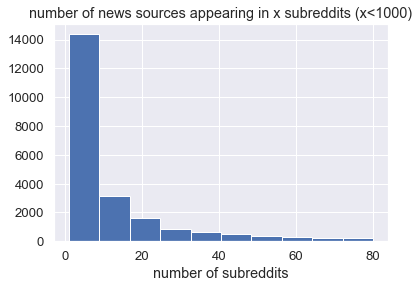

In [376]:
# let's limit to just see number of news sources appearing in 1000 subreddits or less
# scf_1000 = {k:v for k,v in subreddit_count_freq.items() if k<=1000}
scf_1000 = list(itertools.chain.from_iterable(itertools.repeat(k,v) for k,v in subreddit_count_freq.items() if k<=80))
# print(sum(scf_1000.values())*100/len(nss)) # percentage news sources included
print(len(scf_1000)*100/len(nss)) # percentage news sources included
# plt.scatter(scf_1000.keys(), scf_1000.values())
plt.hist(scf_1000)
plt.title("number of news sources appearing in x subreddits (x<1000)")
plt.xlabel("number of subreddits")

In [377]:
scf = list(itertools.chain.from_iterable(itertools.repeat(k,v) for k,v in subreddit_count_freq.items()))

Text(0.5, 1.0, 'number of news sources appearing in x subreddits')

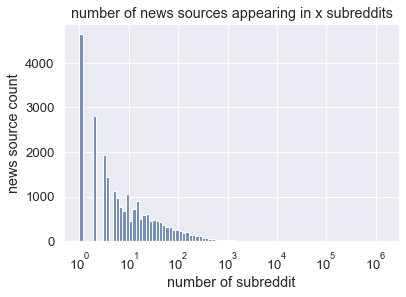

In [378]:
# sns.histplot([math.log(s,10) for s in scf])
sns.histplot(scf, log_scale=True)
plt.xlabel("number of subreddit")
plt.ylabel("news source count")
plt.title("number of news sources appearing in x subreddits")

How many news sources only appear in 10 subreddits or less? what about 9 or 8?

In [379]:
def pct_ns_in_k_subreddits(ks):
    ns_in_i_subreddit = [k for k in subreddit_count if subreddit_count[k] <= ks]
    count = len(ns_in_i_subreddit)
    print("There are {} news sources appearing in only {} subreddits or less ({}%)".format(count, ks, count/len(ns_union)))
    return count/len(ns_union)

In [380]:
pct_ns_in_k_subreddits(5)

There are 11951 news sources appearing in only 5 subreddits or less (0.49209421065634523%)


0.49209421065634523

In [381]:
pct_in_k_subreddits = [(i, pct_ns_in_k_subreddits(i)) for i in range(1000)]

There are 0 news sources appearing in only 0 subreddits or less (0.0%)
There are 4638 news sources appearing in only 1 subreddits or less (0.1909742238326608%)
There are 7449 news sources appearing in only 2 subreddits or less (0.30671992094210654%)
There are 9378 news sources appearing in only 3 subreddits or less (0.3861483982541382%)
There are 10819 news sources appearing in only 4 subreddits or less (0.44548299431771393%)
There are 11951 news sources appearing in only 5 subreddits or less (0.49209421065634523%)
There are 12916 news sources appearing in only 6 subreddits or less (0.5318290373054435%)
There are 13684 news sources appearing in only 7 subreddits or less (0.5634521946800626%)
There are 14376 news sources appearing in only 8 subreddits or less (0.5919459771061517%)
There are 14952 news sources appearing in only 9 subreddits or less (0.6156633451371161%)
There are 15430 news sources appearing in only 10 subreddits or less (0.6353454665239232%)
There are 15876 news sources

There are 22579 news sources appearing in only 101 subreddits or less (0.9297125916165692%)
There are 22599 news sources appearing in only 102 subreddits or less (0.9305361113398666%)
There are 22614 news sources appearing in only 103 subreddits or less (0.9311537511323397%)
There are 22627 news sources appearing in only 104 subreddits or less (0.9316890389524829%)
There are 22646 news sources appearing in only 105 subreddits or less (0.9324713826896154%)
There are 22659 news sources appearing in only 106 subreddits or less (0.9330066705097587%)
There are 22674 news sources appearing in only 107 subreddits or less (0.9336243103022317%)
There are 22689 news sources appearing in only 108 subreddits or less (0.9342419500947048%)
There are 22702 news sources appearing in only 109 subreddits or less (0.934777237914848%)
There are 22719 news sources appearing in only 110 subreddits or less (0.9354772296796509%)
There are 22732 news sources appearing in only 111 subreddits or less (0.93601251

There are 23503 news sources appearing in only 224 subreddits or less (0.9677592028329078%)
There are 23507 news sources appearing in only 225 subreddits or less (0.9679239067775673%)
There are 23514 news sources appearing in only 226 subreddits or less (0.9682121386807214%)
There are 23516 news sources appearing in only 227 subreddits or less (0.9682944906530512%)
There are 23523 news sources appearing in only 228 subreddits or less (0.9685827225562053%)
There are 23529 news sources appearing in only 229 subreddits or less (0.9688297784731944%)
There are 23535 news sources appearing in only 230 subreddits or less (0.9690768343901837%)
There are 23538 news sources appearing in only 231 subreddits or less (0.9692003623486782%)
There are 23542 news sources appearing in only 232 subreddits or less (0.9693650662933377%)
There are 23544 news sources appearing in only 233 subreddits or less (0.9694474182656675%)
There are 23551 news sources appearing in only 234 subreddits or less (0.9697356

There are 23795 news sources appearing in only 343 subreddits or less (0.9797825907930495%)
There are 23799 news sources appearing in only 344 subreddits or less (0.9799472947377089%)
There are 23800 news sources appearing in only 345 subreddits or less (0.9799884707238739%)
There are 23802 news sources appearing in only 346 subreddits or less (0.9800708226962036%)
There are 23802 news sources appearing in only 347 subreddits or less (0.9800708226962036%)
There are 23802 news sources appearing in only 348 subreddits or less (0.9800708226962036%)
There are 23803 news sources appearing in only 349 subreddits or less (0.9801119986823684%)
There are 23805 news sources appearing in only 350 subreddits or less (0.9801943506546982%)
There are 23807 news sources appearing in only 351 subreddits or less (0.9802767026270279%)
There are 23809 news sources appearing in only 352 subreddits or less (0.9803590545993577%)
There are 23809 news sources appearing in only 353 subreddits or less (0.9803590

There are 23927 news sources appearing in only 484 subreddits or less (0.9852178209668122%)
There are 23928 news sources appearing in only 485 subreddits or less (0.985258996952977%)
There are 23929 news sources appearing in only 486 subreddits or less (0.9853001729391418%)
There are 23931 news sources appearing in only 487 subreddits or less (0.9853825249114716%)
There are 23931 news sources appearing in only 488 subreddits or less (0.9853825249114716%)
There are 23931 news sources appearing in only 489 subreddits or less (0.9853825249114716%)
There are 23932 news sources appearing in only 490 subreddits or less (0.9854237008976365%)
There are 23934 news sources appearing in only 491 subreddits or less (0.9855060528699663%)
There are 23934 news sources appearing in only 492 subreddits or less (0.9855060528699663%)
There are 23934 news sources appearing in only 493 subreddits or less (0.9855060528699663%)
There are 23935 news sources appearing in only 494 subreddits or less (0.98554722

There are 23997 news sources appearing in only 583 subreddits or less (0.988100139998353%)
There are 23999 news sources appearing in only 584 subreddits or less (0.9881824919706828%)
There are 23999 news sources appearing in only 585 subreddits or less (0.9881824919706828%)
There are 24000 news sources appearing in only 586 subreddits or less (0.9882236679568476%)
There are 24001 news sources appearing in only 587 subreddits or less (0.9882648439430124%)
There are 24001 news sources appearing in only 588 subreddits or less (0.9882648439430124%)
There are 24001 news sources appearing in only 589 subreddits or less (0.9882648439430124%)
There are 24001 news sources appearing in only 590 subreddits or less (0.9882648439430124%)
There are 24001 news sources appearing in only 591 subreddits or less (0.9882648439430124%)
There are 24001 news sources appearing in only 592 subreddits or less (0.9882648439430124%)
There are 24002 news sources appearing in only 593 subreddits or less (0.98830601

There are 24050 news sources appearing in only 710 subreddits or less (0.990282467265091%)
There are 24050 news sources appearing in only 711 subreddits or less (0.990282467265091%)
There are 24052 news sources appearing in only 712 subreddits or less (0.9903648192374207%)
There are 24052 news sources appearing in only 713 subreddits or less (0.9903648192374207%)
There are 24052 news sources appearing in only 714 subreddits or less (0.9903648192374207%)
There are 24054 news sources appearing in only 715 subreddits or less (0.9904471712097505%)
There are 24054 news sources appearing in only 716 subreddits or less (0.9904471712097505%)
There are 24055 news sources appearing in only 717 subreddits or less (0.9904883471959154%)
There are 24057 news sources appearing in only 718 subreddits or less (0.990570699168245%)
There are 24057 news sources appearing in only 719 subreddits or less (0.990570699168245%)
There are 24057 news sources appearing in only 720 subreddits or less (0.99057069916

There are 24073 news sources appearing in only 805 subreddits or less (0.9912295149468829%)
There are 24073 news sources appearing in only 806 subreddits or less (0.9912295149468829%)
There are 24074 news sources appearing in only 807 subreddits or less (0.9912706909330479%)
There are 24074 news sources appearing in only 808 subreddits or less (0.9912706909330479%)
There are 24074 news sources appearing in only 809 subreddits or less (0.9912706909330479%)
There are 24074 news sources appearing in only 810 subreddits or less (0.9912706909330479%)
There are 24074 news sources appearing in only 811 subreddits or less (0.9912706909330479%)
There are 24074 news sources appearing in only 812 subreddits or less (0.9912706909330479%)
There are 24075 news sources appearing in only 813 subreddits or less (0.9913118669192127%)
There are 24075 news sources appearing in only 814 subreddits or less (0.9913118669192127%)
There are 24075 news sources appearing in only 815 subreddits or less (0.9913118

There are 24094 news sources appearing in only 902 subreddits or less (0.9920942106563452%)
There are 24094 news sources appearing in only 903 subreddits or less (0.9920942106563452%)
There are 24094 news sources appearing in only 904 subreddits or less (0.9920942106563452%)
There are 24095 news sources appearing in only 905 subreddits or less (0.9921353866425101%)
There are 24095 news sources appearing in only 906 subreddits or less (0.9921353866425101%)
There are 24095 news sources appearing in only 907 subreddits or less (0.9921353866425101%)
There are 24095 news sources appearing in only 908 subreddits or less (0.9921353866425101%)
There are 24095 news sources appearing in only 909 subreddits or less (0.9921353866425101%)
There are 24095 news sources appearing in only 910 subreddits or less (0.9921353866425101%)
There are 24095 news sources appearing in only 911 subreddits or less (0.9921353866425101%)
There are 24095 news sources appearing in only 912 subreddits or less (0.9921353

Text(0.5, 1.0, 'proportion of news sources appearing in x subreddits or less')

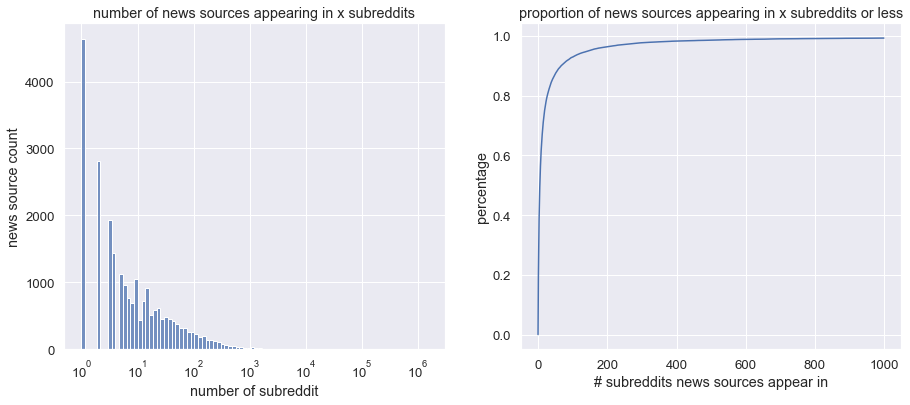

In [382]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,6))
sns.set(font_scale = 1.2)

sns.histplot(scf, log_scale=True, ax=ax1)
ax1.set_xlabel("number of subreddit")
ax1.set_ylabel("news source count")
ax1.set_title("number of news sources appearing in x subreddits")

sns.lineplot(x=[k[0] for k in pct_in_k_subreddits],
             y=[k[1] for k in pct_in_k_subreddits],
            ax=ax2)
ax2.set_ylabel("percentage")
ax2.set_xlabel("# subreddits news sources appear in")
ax2.set_title("proportion of news sources appearing in x subreddits or less")

In [383]:
# mean
statistics.mean(scf)

133.65992753026435

In [384]:
# median
statistics.median(scf)

6.0

## For each subreddit let's count how many news sources were mentioned in it

Counting how many news sources were mentioned in each subreddit

In [385]:
nsc_count = dict()
for ns in sr_union:
    nsc_count[ns] = len(set(subreddit_ns_jan.get(ns, dict()).keys()) 
                               | set(subreddit_ns_feb.get(ns, dict()).keys()) 
                               | set(subreddit_ns_march.get(ns, dict()).keys()) 
                               | set(subreddit_ns_april.get(ns, dict()).keys())
                               | set(subreddit_ns_may.get(ns, dict()).keys()) 
                               | set(subreddit_ns_jun.get(ns, dict()).keys()))

`nsc_count` stores how many news sources appear in each subreddit.

In [386]:
nsc_count['aww']

149

In [387]:
nsc_count_freq = dict(Counter(nsc_count.values()).most_common())
nsc_count_freq

{1: 1295615,
 2: 179605,
 3: 51552,
 4: 25066,
 5: 14997,
 6: 9431,
 7: 6524,
 8: 4855,
 9: 3897,
 10: 3000,
 11: 2433,
 12: 2048,
 13: 1713,
 14: 1411,
 15: 1196,
 16: 1148,
 17: 929,
 18: 818,
 19: 755,
 21: 633,
 20: 617,
 22: 567,
 23: 500,
 25: 466,
 24: 453,
 26: 393,
 27: 383,
 28: 336,
 30: 332,
 29: 316,
 31: 292,
 32: 249,
 33: 237,
 35: 224,
 34: 215,
 36: 198,
 37: 190,
 39: 185,
 42: 173,
 38: 169,
 43: 152,
 41: 150,
 40: 138,
 45: 135,
 47: 125,
 49: 123,
 50: 123,
 46: 121,
 48: 120,
 44: 117,
 55: 100,
 52: 99,
 53: 99,
 51: 93,
 59: 90,
 58: 84,
 62: 81,
 54: 80,
 56: 78,
 61: 74,
 60: 67,
 63: 65,
 57: 64,
 68: 58,
 65: 57,
 64: 54,
 76: 54,
 71: 54,
 66: 50,
 70: 49,
 75: 48,
 69: 48,
 74: 47,
 67: 46,
 78: 44,
 72: 44,
 81: 43,
 89: 42,
 73: 40,
 82: 40,
 77: 38,
 90: 37,
 84: 36,
 79: 36,
 83: 36,
 80: 35,
 99: 32,
 87: 32,
 88: 30,
 85: 30,
 97: 30,
 94: 28,
 98: 28,
 91: 28,
 104: 27,
 103: 27,
 86: 26,
 100: 26,
 110: 25,
 114: 25,
 92: 24,
 95: 24,
 101: 24,
 

`nsc_count_freq` keeps track of how many news sources appear in *n* subreddits for all possible *n*.

In [388]:
max(nsc_count_freq.keys())

3609

In [389]:
nsc_ranked = Counter(nsc_count).most_common()

for t in nsc_ranked:
    sr, co = t
    if co > 2000:
        print(f"{sr} has {co} news sources mentioned in it.")

COVID_CANADA has 3609 news sources mentioned in it.
news has 3533 news sources mentioned in it.
politics has 3118 news sources mentioned in it.
todayilearned has 3036 news sources mentioned in it.
Coronavirus has 2669 news sources mentioned in it.
worldnews has 2630 news sources mentioned in it.
nottheonion has 2493 news sources mentioned in it.
prisons has 2330 news sources mentioned in it.
NoFilterNews has 2276 news sources mentioned in it.
conspiracy has 2173 news sources mentioned in it.
wallstreetbets has 2090 news sources mentioned in it.


In [390]:
sum(nsc_count_freq.values()) == len(sr_union)

True

In [391]:
import itertools

In [392]:
nsc = list(itertools.chain.from_iterable(itertools.repeat(k,v) for k,v in nsc_count_freq.items()))

Text(0.5, 1.0, 'number of subreddits with x news sources')

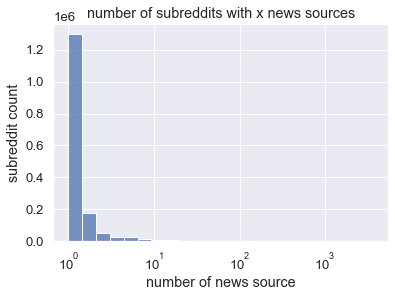

In [393]:
sns.histplot(nsc, log_scale=True)
plt.xlabel("number of news source")
plt.ylabel("subreddit count")
plt.title("number of subreddits with x news sources")

How many subreddits only mentioned 5 news sources or less?

In [394]:
def pct_subreddits_mentioning_k_newssources(ks):
    sr_mention_i_nsc = [k for k in nsc_count if nsc_count[k] <= ks]
    count = len(sr_mention_i_nsc)
    print("There are {} subreddits mentioning in only {} news sources or less ({}%)".format(count, ks, count/len(sr_union)))
    return count/len(sr_union)

In [395]:
pct_subreddits_mentioning_k_newssources(1)

There are 1295615 subreddits mentioning in only 1 news sources or less (0.799900106252867%)


0.799900106252867

In [396]:
# mean
statistics.mean(nsc)

2.00408897581744

In [397]:
# median
statistics.median(nsc)

1

## upvote based weight vs comment based weight 

Do they have correlation?

Let's look at January's data

In [431]:
upvote_based = [ns_subreddit_01[ns][sr][1] for ns in ns_subreddit_01 for sr in ns_subreddit_01[ns]]
comment_based = [ns_subreddit_01[ns][sr][2] for ns in ns_subreddit_01 for sr in ns_subreddit_01[ns]]
unweighted = [ns_subreddit_01[ns][sr][0] for ns in ns_subreddit_01 for sr in ns_subreddit_01[ns]]

(-5000.0, 150000.0)

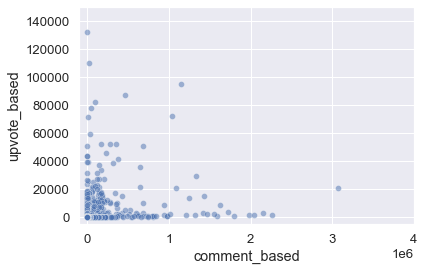

In [458]:
sns.scatterplot(x=comment_based, y=upvote_based, alpha=0.5)
plt.xlabel("comment_based")
plt.ylabel("upvote_based")
plt.xlim([-100000,4000000])
plt.ylim([-5000,150000])

Text(0, 0.5, 'upvote_based')

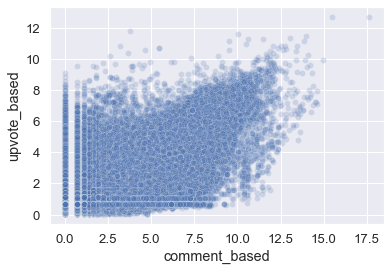

In [464]:
a = sns.scatterplot(x=np.log(np.array([c+1 for c in comment_based])), y=np.log(np.array([u+1 for u in upvote_based])), alpha=0.2)
plt.xlabel("comment_based")
plt.ylabel("upvote_based")

In [467]:
from scipy.stats import pearsonr

In [469]:
corr, _ = pearsonr(np.log(np.array([c+1 for c in comment_based])), np.log(np.array([u+1 for u in upvote_based])))
corr

0.6435240742264886

In [470]:
corr_raw, _ = pearsonr(comment_based, upvote_based)
corr_raw

0.6208857306938401

## I filter out news sources that are just too general

In [398]:
len(ns_union)

24286

In [399]:
non_outlier = [k for k in ns_union if subreddit_count[k] <= 1048 and subreddit_count[k] > 5]
len(non_outlier)

12172

In [400]:
subreddit_count['washingtonpost.com']

4334

In [401]:
'washingtonpost.com' in non_outlier

False

In [402]:
non_outlier

['duden.de',
 'takiedela.ru',
 'reporterherald.com',
 'i95rock.com',
 'theemeraldmagazine.com',
 'vtdigger.org',
 'leafly.com',
 'vogue.com',
 'reddeeradvocate.com',
 'blockchain.news',
 'chip.de',
 'tech.eu',
 'spaceflightnow.com',
 'thenewsherald.com',
 'themorningbulletin.com.au',
 'kurzweilai.net',
 'diyphotography.net',
 'william-reed.com',
 'kfvs12.com',
 'abc7ny.com',
 'religiondispatches.org',
 'hdblog.it',
 'maisonneuve.org',
 'animenewsnetwork.com',
 'theshadowleague.com',
 'vrscout.com',
 'sundayobserver.lk',
 'judicialwatch.org',
 'churchtimes.co.uk',
 'nfpa.org',
 'blogspot.com.au',
 'lemonde.fr',
 'ky3.com',
 'sourcingjournal.com',
 'chesterstandard.co.uk',
 'plainsite.org',
 'theglobepost.com',
 'tagesspiegel.de',
 'pubg.com',
 'duke.edu',
 'numerama.com',
 'otto.de',
 'state.fl.us',
 'pureplaystation.com',
 'slantmagazine.com',
 'monsterenergy.com',
 'hoodline.com',
 'sparktoro.com',
 'celebritynetworth.com',
 'ultimateclassicrock.com',
 'theonion.com',
 'loe.org',
 'sg

## Cluster Try Out

First, I make a list of subreddits with fixed order, where I only include subreddits where our non_outlier news sources are mentioned in.

In [403]:
# subreddits = subs
subreddits = set()
nsr_files = [ns_subreddit_01, ns_subreddit_02, ns_subreddit_03, ns_subreddit_04, ns_subreddit_05, ns_subreddit_06]
# first, I filter for only the subreddits in which our news sources are mentioned
for n in non_outlier:
    subreddits = (subreddits | set(ns_subreddit_01.get(n, dict()).keys()) 
                               | set(ns_subreddit_02.get(n, dict()).keys()) 
                               | set(ns_subreddit_03.get(n, dict()).keys()) 
                               | set(ns_subreddit_04.get(n, dict()).keys())
                               | set(ns_subreddit_05.get(n, dict()).keys()) 
                               | set(ns_subreddit_06.get(n, dict()).keys()))
subreddits = list(subreddits)
len(subreddits)

81351

There are 9195 subreddits.

In [404]:
subreddits[-10:]

['IdleHeroes',
 'DDR',
 'LGBTARMY',
 'u_williamletzer',
 'bentoboxent',
 'JewishYouthChatline',
 'u_rashikatalyst',
 'CiscoUCS',
 '2020Election',
 'Apple_Fitness']

If I should order them later, I can do so.

## Incorporating subscribers information

In [405]:
pd1 = os.path.split(os.getcwd())[0]
data_fp = os.path.join(pd1,"data/gm-newssources-subreddits")
dfp = os.path.join(pd1,"data")

In [406]:
sfp = os.path.join(pd1,"data/subreddits")

In [407]:
# Let's only use the subreddits that have lots of subscribers
with open (os.path.join(sfp,"subreddit_subscribers.json"), "r", encoding = "utf-8") as infile:
    subreddit_subscribers = json.load(infile)

In [408]:
subreddit_subscribers['politics']

6201779

In [409]:
len(subreddit_subscribers)

49055

In [410]:
len(subreddits)

81351

In [411]:
subreddits_w_subc = [k for k in subreddits if k in subreddit_subscribers]
len(subreddits_w_subc)

31277

It seems that there are `None` values, so let's filter those subreddits out.

In [412]:
print([s for s in subreddits_w_subc if subreddit_subscribers[s] is None])

['RedditMobTest', 'WaterCoolerWednesday', 'transportation_games', 'JKRowling', 'u_robertinoc', 'LoveForLandlords', 'FisherFamilyMurders', 'u_dollymac72', 'DystopianFuture', 'Lsstestaccount', 'u_supplier4buyer']


In [413]:
subreddits_w_subc = [s for s in subreddits_w_subc if subreddit_subscribers[s] is not None]

In [414]:
len(subreddits_w_subc)

31266

Now, I will sort the 8,294 subreddits based on the # of their subscribers in a descending order.

In [415]:
srs_all = sorted(subreddits_w_subc, key= lambda x: subreddit_subscribers[x], reverse= True)

Text(0.5, 1.0, 'Subreddits Subscribers')

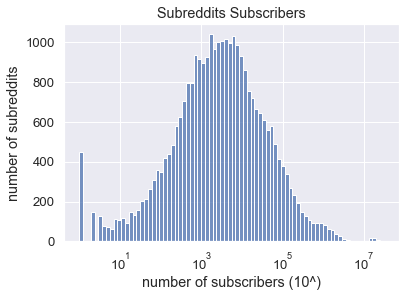

In [416]:
# plt.hist([math.log(subreddit_subscribers[s],10) for s in srs_all if subreddit_subscribers[s] > 0])
sns.histplot([subreddit_subscribers[s] for s in srs_all if subreddit_subscribers[s]>0], log_scale=True)
# plt.hist([subreddit_subscribers[s] for s in srs_all if subreddit_subscribers[s] > 0])
# plt.yscale("log")
# plt.xscale("log")
plt.ylabel("number of subreddits")
plt.xlabel("number of subscribers (10^)")
plt.title("Subreddits Subscribers")
# log scale for both x and y

Which subreddits are the top three?

In [417]:
print([(s,subreddit_subscribers[s]) for s in srs_all if subreddit_subscribers[s]>25000000])

[('funny', 31060166), ('gaming', 26628444), ('aww', 25197817)]


In [418]:
dir(math)

['__doc__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 'acos',
 'acosh',
 'asin',
 'asinh',
 'atan',
 'atan2',
 'atanh',
 'ceil',
 'comb',
 'copysign',
 'cos',
 'cosh',
 'degrees',
 'dist',
 'e',
 'erf',
 'erfc',
 'exp',
 'expm1',
 'fabs',
 'factorial',
 'floor',
 'fmod',
 'frexp',
 'fsum',
 'gamma',
 'gcd',
 'hypot',
 'inf',
 'isclose',
 'isfinite',
 'isinf',
 'isnan',
 'isqrt',
 'ldexp',
 'lgamma',
 'log',
 'log10',
 'log1p',
 'log2',
 'modf',
 'nan',
 'perm',
 'pi',
 'pow',
 'prod',
 'radians',
 'remainder',
 'sin',
 'sinh',
 'sqrt',
 'tan',
 'tanh',
 'tau',
 'trunc']

In [419]:
list(subreddit_subscribers.values()).count(None)

25

In [420]:
statistics.median([k for k in list(subreddit_subscribers.values()) if k is not None])

1420.0

In [421]:
statistics.mean([k for k in list(subreddit_subscribers.values()) if k is not None])

50070.832184376915

## Clusterings using 1000 subreddits

In [422]:
srs = srs_all

In [350]:
a = {"a": 1, "b": 2}
b = {"b": 1, "c": 2}
res = {**a, **b}
res

{'a': 1, 'b': 1, 'c': 2}

For each news source, I create a list of length 1000 (# subreddits), and the values would be the weighted count of how many times that news source appears in subreddit index *i*, where the index is based on the list `srs`. The weighted count will be based on the upvote_ratio as well as number of comments.

In [351]:
# here I will cast the inner dictionaries of ns_subreddits to be Counter so I can avoid a lot of if-else statements
files = [ns_subreddit_01, ns_subreddit_02, ns_subreddit_03, ns_subreddit_04, ns_subreddit_05, ns_subreddit_06]
for f in files:
    for k in f: # k is each news source
        for ns in f[k]:
            # averaging based on weighted counts
            count, upv, comm = f[k][ns]
            avg = (upv + comm)/count
            f[k][ns] = avg
        f[k] = Counter(f[k])

TypeError: cannot unpack non-iterable float object

In [259]:
ns_sr_rep = dict()
default_counter = Counter() # to avoid a lot of if else statements

# for ns in nss:
for ns in non_outlier:
    # making sure the ordering follows `srs` based on subscribers
    ns_sr_rep[ns] = [ns_subreddit_01.get(ns, default_counter)[srs[idx]] 
                     + ns_subreddit_02.get(ns, default_counter)[srs[idx]] 
                     + ns_subreddit_03.get(ns, default_counter)[srs[idx]] 
                     + ns_subreddit_04.get(ns, default_counter)[srs[idx]] 
                     + ns_subreddit_05.get(ns, default_counter)[srs[idx]] 
                     + ns_subreddit_06.get(ns, default_counter)[srs[idx]] 
                     for idx in range(len(srs))]

Let's see one example of representation for `nytimes.com`.

In [260]:
len(ns_sr_rep['ottawacitizen.com'])

50

In [261]:
ns_sr_rep['ottawacitizen.com']

[0,
 0,
 0,
 0,
 0,
 861.035,
 0,
 0,
 0,
 0,
 393.845,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 68.02000000000001,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

Now, I will cast those list representation values to be numpy arrays so I can preprocess them easily. Further, I will normalize each array.

*side note: `preprocessing.normalize` vs `standardscaler`*

In [262]:
preprocessing.normalize(np.array([[1,100,2,3]]))

array([[0.00999301, 0.99930073, 0.01998601, 0.02997902]])

In [263]:
scaler = StandardScaler()
scaler.fit_transform(np.array([[1,100,2,3]]))

array([[0., 0., 0., 0.]])

Now I'm thinking, should I *normalize* or *standardize*?

In [264]:
# for ns in ns_sr_rep:
#     rep = ns_sr_rep[ns]
#     ns_sr_rep[ns] = preprocessing.normalize(np.array([rep]))

## K-Means

Without standardization.

First, I need to find optimum `k`.

In [266]:
kmeans = KMeans(init = "k-means++",
               n_clusters = 5,
               n_init = 10,
               max_iter = 100)

Freezing the list for representations and the news sources.

In [267]:
items = list(ns_sr_rep.items())
items[3]

('i95rock.com',
 [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0])

In [268]:
ns_repr, ns_fixed = np.array([v[1] for v in items]), list([v[0] for v in items])

In [269]:
kmeans.fit([v for v in ns_sr_rep.values()])

KMeans(max_iter=100, n_clusters=5)

In [270]:
for i,ns in enumerate(ns_fixed):
    if (ns_sr_rep[ns] == ns_repr[i]).all():
        pass
    else:
        print("False")
print("True")

True


In [271]:
kmeans.inertia_

2489349969.912243

In [272]:
kmeans.n_iter_

17

In [278]:
Counter(kmeans.labels_)

Counter({0: 11798, 3: 20, 4: 78, 2: 257, 1: 19})

**Choosing the appropriate number of clusters**

1. Elbow method

In [279]:
kmeans_kwargs = {
    "init": "random",
    "n_init": 10,
    "max_iter": 300,
    "random_state": 360
}

In [280]:
sse = []
for k in range(1,20):
    kmeans = KMeans(n_clusters = k, **kmeans_kwargs)
    kmeans.fit(ns_repr)
    sse.append(kmeans.inertia_)
    print(f"have done {k} rounds, current sse is {sse}")

have done 1 rounds, current sse is [3742986473.2936273]
have done 2 rounds, current sse is [3742986473.2936273, 3234417042.1679316]
have done 3 rounds, current sse is [3742986473.2936273, 3234417042.1679316, 2955216016.857941]
have done 4 rounds, current sse is [3742986473.2936273, 3234417042.1679316, 2955216016.857941, 2695873424.789785]
have done 5 rounds, current sse is [3742986473.2936273, 3234417042.1679316, 2955216016.857941, 2695873424.789785, 2488313014.3627152]
have done 6 rounds, current sse is [3742986473.2936273, 3234417042.1679316, 2955216016.857941, 2695873424.789785, 2488313014.3627152, 2293210806.7762027]
have done 7 rounds, current sse is [3742986473.2936273, 3234417042.1679316, 2955216016.857941, 2695873424.789785, 2488313014.3627152, 2293210806.7762027, 2098664065.763022]
have done 8 rounds, current sse is [3742986473.2936273, 3234417042.1679316, 2955216016.857941, 2695873424.789785, 2488313014.3627152, 2293210806.7762027, 2098664065.763022, 2014196960.830707]
have d

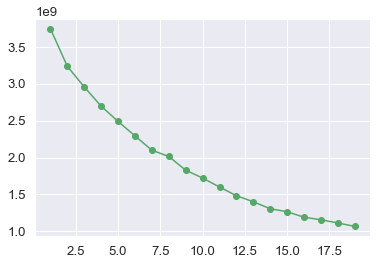

In [281]:
plt.plot(range(1,20),sse,"go-")

In [282]:
for k in range(20,41):
    kmeans = KMeans(n_clusters = k, **kmeans_kwargs)
    kmeans.fit(ns_repr)
    sse.append(kmeans.inertia_)
    print(f"have done {k} rounds, current sse is {sse}")

have done 20 rounds, current sse is [3742986473.2936273, 3234417042.1679316, 2955216016.857941, 2695873424.789785, 2488313014.3627152, 2293210806.7762027, 2098664065.763022, 2014196960.830707, 1828149792.6682768, 1722006067.421706, 1600438086.725546, 1483067977.4693468, 1400449889.892366, 1306601429.7751622, 1265379480.4209607, 1191656941.3570268, 1156324662.6761339, 1114299811.5887597, 1067129265.2241528, 1007128251.3336804]
have done 21 rounds, current sse is [3742986473.2936273, 3234417042.1679316, 2955216016.857941, 2695873424.789785, 2488313014.3627152, 2293210806.7762027, 2098664065.763022, 2014196960.830707, 1828149792.6682768, 1722006067.421706, 1600438086.725546, 1483067977.4693468, 1400449889.892366, 1306601429.7751622, 1265379480.4209607, 1191656941.3570268, 1156324662.6761339, 1114299811.5887597, 1067129265.2241528, 1007128251.3336804, 966015297.6944139]
have done 22 rounds, current sse is [3742986473.2936273, 3234417042.1679316, 2955216016.857941, 2695873424.789785, 248831

have done 35 rounds, current sse is [3742986473.2936273, 3234417042.1679316, 2955216016.857941, 2695873424.789785, 2488313014.3627152, 2293210806.7762027, 2098664065.763022, 2014196960.830707, 1828149792.6682768, 1722006067.421706, 1600438086.725546, 1483067977.4693468, 1400449889.892366, 1306601429.7751622, 1265379480.4209607, 1191656941.3570268, 1156324662.6761339, 1114299811.5887597, 1067129265.2241528, 1007128251.3336804, 966015297.6944139, 921800899.1342736, 901762829.3856338, 876828075.0420979, 847503639.6679804, 830839780.7020626, 798059365.1603899, 791723158.6891322, 721297569.7979159, 698322207.6846948, 671007699.0112892, 641011232.8167658, 632059196.108287, 600862222.2112212, 592475449.6840172]
have done 36 rounds, current sse is [3742986473.2936273, 3234417042.1679316, 2955216016.857941, 2695873424.789785, 2488313014.3627152, 2293210806.7762027, 2098664065.763022, 2014196960.830707, 1828149792.6682768, 1722006067.421706, 1600438086.725546, 1483067977.4693468, 1400449889.8923

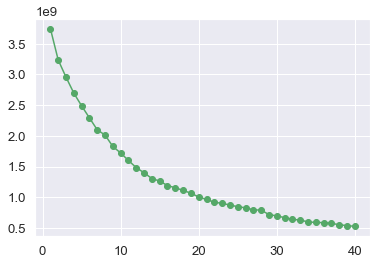

In [283]:
plt.plot(range(1,41),sse,"go-")

In [284]:
kl = KneeLocator(range(1,41), sse, curve="convex", direction="decreasing")

In [285]:
kl.elbow

14

**Using Silhouette Coefficient**

In [287]:
sc = []
new_sse = []
for k in range(2,50):
    kmeans = KMeans(n_clusters = k, **kmeans_kwargs)
    kmeans.fit(ns_repr)
    score = silhouette_score(ns_repr, kmeans.labels_)
    sc.append(score)
    new_sse.append(kmeans.inertia_)
    print("step {}".format(k))

step 2
step 3
step 4
step 5
step 6
step 7
step 8
step 9
step 10
step 11
step 12
step 13
step 14
step 15
step 16
step 17
step 18
step 19
step 20
step 21
step 22
step 23
step 24
step 25
step 26
step 27
step 28
step 29
step 30
step 31
step 32
step 33
step 34
step 35
step 36
step 37
step 38
step 39
step 40
step 41
step 42
step 43
step 44
step 45
step 46
step 47
step 48
step 49


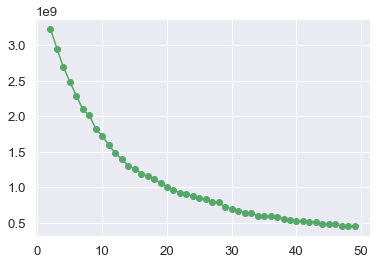

In [289]:
# for sse
plt.plot(range(2,50), new_sse, "go-")

In [291]:
kl_new = KneeLocator(range(2,50), new_sse, curve="convex", direction="decreasing")
kl_new.elbow

20

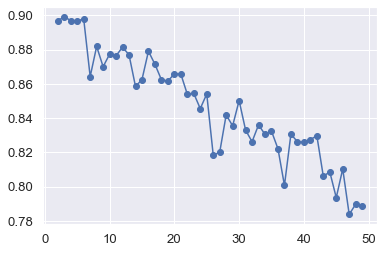

In [292]:
# for silhouette coefficient
plt.plot(range(2,50), sc, "bo-")

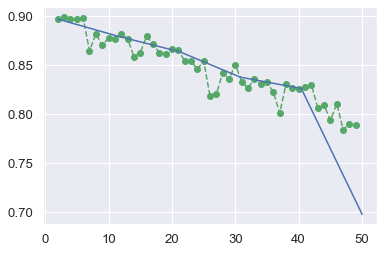

In [294]:


spl = make_interp_spline(range(2,50), sc, k=3)  # type: BSpline

xs = np.linspace(2, 50, 6)
ys = spl(xs)

plt.plot(range(2,50), sc, "go--")
plt.plot(xs, ys, "b-")

Let's choose k = 10

In [309]:
kmeans = KMeans(n_clusters = 8, init="k-means++", n_init = 50, max_iter = 500, random_state = 360)
kmeans.fit(ns_repr)

KMeans(max_iter=500, n_init=50, random_state=360)

In [68]:
dir(kmeans)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_algorithm',
 '_check_feature_names',
 '_check_mkl_vcomp',
 '_check_n_features',
 '_check_params',
 '_check_test_data',
 '_estimator_type',
 '_get_param_names',
 '_get_tags',
 '_init_centroids',
 '_more_tags',
 '_n_init',
 '_n_threads',
 '_repr_html_',
 '_repr_html_inner',
 '_repr_mimebundle_',
 '_tol',
 '_transform',
 '_validate_center_shape',
 '_validate_data',
 'algorithm',
 'cluster_centers_',
 'copy_x',
 'fit',
 'fit_predict',
 'fit_transform',
 'get_params',
 'inertia_',
 'init',
 'labels_',
 'max_iter',
 'n_clusters',
 'n_features_in_',
 'n_init',
 'n_iter_',
 'predict',
 'random_

In [310]:
kmeans.labels_

array([0, 0, 0, ..., 0, 0, 0])

In [311]:
set(kmeans.labels_)

{0, 1, 2, 3, 4, 5, 6, 7}

In [312]:
Counter(kmeans.labels_)

Counter({0: 11739, 1: 20, 4: 103, 3: 82, 2: 177, 7: 37, 6: 13, 5: 1})

**Let's see the `PCA` clusterings using these labelings**

In [313]:
pca = PCA(n_components = 2)

In [314]:
pca_2d = pca.fit_transform(ns_repr)
pca_2d

array([[-42.35311673, -33.43137476],
       [-42.35311673, -33.43137476],
       [240.46705541, -62.42932223],
       ...,
       [-42.18902975, -31.71037849],
       [-34.59642545,   2.08783803],
       [-42.35311673, -33.43137476]])

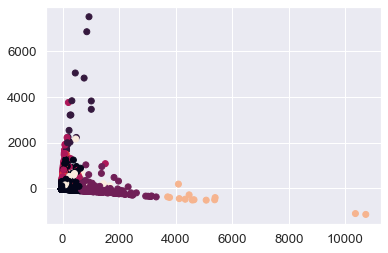

In [316]:
plt.scatter([v[0] for v in pca_2d], [v[1] for v in pca_2d], c = kmeans.labels_)

**Let's investigate each cluster**

In [317]:
len(ns_sr_rep)

12172

In [318]:
len(kmeans.labels_)

12172

In [319]:
clustered = defaultdict(list)
for idx,ns in enumerate(ns_fixed):
    c = kmeans.labels_[idx]
    clustered[c].append(ns)

In [320]:
print([len(clustered[i]) for i in range(10)])

[11739, 20, 177, 82, 103, 1, 13, 37, 0, 0]


Let's see in terms of percentage

In [321]:
cluster_lens = [len(clustered[i]) for i in range(10)]

In [322]:
print([round(k*100/sum(cluster_lens),2) for k in cluster_lens])

[96.44, 0.16, 1.45, 0.67, 0.85, 0.01, 0.11, 0.3, 0.0, 0.0]


 **could do iterative clusters for ^**

In [325]:
clustered[2]

['opb.org',
 'actionnewsnow.com',
 'okcfox.com',
 'wmot.org',
 'aviationweek.com',
 'vulture.com',
 'wtop.com',
 'jns.org',
 'dutchnews.nl',
 'woodworkingnetwork.com',
 'wvmetronews.com',
 'nbc-2.com',
 'nbc12.com',
 'fox2detroit.com',
 'wvnstv.com',
 'thelily.com',
 'kbzk.com',
 'kktv.com',
 'rentonreporter.com',
 'montreal.ctvnews.ca',
 'nbcchicago.com',
 'nwaonline.com',
 'theadvocate.com',
 'whdh.com',
 'expressnews.com',
 'fox29.com',
 'mlive.com',
 'lbc.co.uk',
 'uptownmessenger.com',
 'nbcsports.com',
 'duluthnewstribune.com',
 'wfmj.com',
 'fox26houston.com',
 'abc15.com',
 'abc30.com',
 'toronto.citynews.ca',
 'wqow.com',
 'kiro7.com',
 'wgem.com',
 'prpeak.com',
 'denverpost.com',
 'kpvi.com',
 'fox4news.com',
 'desmoinesregister.com',
 'metrotimes.com',
 'local12.com',
 'fox7austin.com',
 'tmj4.com',
 'theregister.com',
 'news4sanantonio.com',
 'govexec.com',
 'fox11online.com',
 'wearemitu.com',
 'wsvn.com',
 'wafb.com',
 'nzherald.co.nz',
 'fox21news.com',
 'chicagocrusade

## DBSCAN clustering

In [326]:
from sklearn.cluster import DBSCAN

First try out.

In [327]:
dbscan = DBSCAN(eps=0.01)

In [328]:
ds_clusters = dbscan.fit(ns_repr)

In [329]:
dbs_labels = ds_clusters.labels_
len(dbs_labels)

12172

In [330]:
np.unique(dbs_labels)

array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
       16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32,
       33, 34, 35, 36, 37], dtype=int64)

In [331]:
dbscan_clusters = defaultdict(list)
for idx, c in enumerate(list(dbs_labels)):
    dbscan_clusters[c].append(ns_fixed[idx])

In [332]:
for c in range(-1, 38):
    print("number of ns in cluster {}: {}".format(c, len(dbscan_clusters[c])))

number of ns in cluster -1: 6236
number of ns in cluster 0: 5206
number of ns in cluster 1: 13
number of ns in cluster 2: 102
number of ns in cluster 3: 22
number of ns in cluster 4: 6
number of ns in cluster 5: 12
number of ns in cluster 6: 192
number of ns in cluster 7: 7
number of ns in cluster 8: 31
number of ns in cluster 9: 53
number of ns in cluster 10: 37
number of ns in cluster 11: 5
number of ns in cluster 12: 20
number of ns in cluster 13: 17
number of ns in cluster 14: 5
number of ns in cluster 15: 26
number of ns in cluster 16: 8
number of ns in cluster 17: 5
number of ns in cluster 18: 5
number of ns in cluster 19: 6
number of ns in cluster 20: 12
number of ns in cluster 21: 8
number of ns in cluster 22: 24
number of ns in cluster 23: 5
number of ns in cluster 24: 13
number of ns in cluster 25: 7
number of ns in cluster 26: 5
number of ns in cluster 27: 6
number of ns in cluster 28: 10
number of ns in cluster 29: 5
number of ns in cluster 30: 5
number of ns in cluster 31:

Let's investigate some of the clusters

In [342]:
dbscan_clusters[9]

['smdailyjournal.com',
 'news-gazette.com',
 'sakshi.com',
 'tortoisemedia.com',
 'berlingske.dk',
 'eleconomista.com.mx',
 'letelegramme.fr',
 'odishatv.in',
 'moneylife.in',
 'thelastamericanvagabond.com',
 'hankookilbo.com',
 'ekstrabladet.dk',
 'todayheadline.co',
 'wellnessmama.com',
 'ticotimes.net',
 'eldiariony.com',
 'carehome.co.uk',
 'phnompenhpost.com',
 'mediafax.ro',
 'rcrwireless.com',
 'wigantoday.net',
 'parismatch.com',
 'biznews.com',
 'vedomosti.ru',
 'iz.ru',
 'dailycardinal.com',
 'fashionweekdaily.com',
 'searchenginewatch.com',
 'techinasia.com',
 'azernews.az',
 'surfacemag.com',
 'animalpolitico.com',
 'icirnigeria.org',
 'salaamgateway.com',
 'n-tv.de',
 'vavel.com',
 'myfitnesspal.com',
 'thecitizen.com',
 '2gb.com',
 'dopemagazine.com',
 'livehindustan.com',
 'niagarathisweek.com',
 'lowyat.net',
 'kbjr6.com',
 'smartinsights.com',
 'theglobalist.com',
 'atheistrepublic.com',
 'dinheirovivo.pt',
 'sabah.com.tr',
 'lenta.ru',
 'goldswitzerland.com',
 'mounta

In [147]:
dbscan_clusters[1]

[]

**Finding optimum `epsilon` for dbscan**

References: 

https://towardsdatascience.com/machine-learning-clustering-dbscan-determine-the-optimal-value-for-epsilon-eps-python-example-3100091cfbc

https://iopscience.iop.org/article/10.1088/1755-1315/31/1/012012/pdf

In [343]:
from sklearn.neighbors import NearestNeighbors

In [344]:
neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(ns_repr)
distances, indices = nbrs.kneighbors(ns_repr)

(0.0, 0.01)

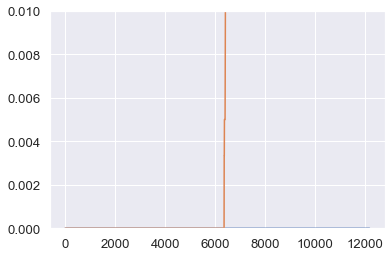

In [348]:
distances = np.sort(distances, axis=0)
# distances = distances[:,1]
plt.plot(distances)
plt.ylim((0,0.01))

I don't think any epsilon makes sense here.

NameError: name 'subreddit_ns_jun' is not defined